<a href="https://colab.research.google.com/github/IamJamesRooke/ztm_ai_agents/blob/master/Interview_Coach_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Work Flow
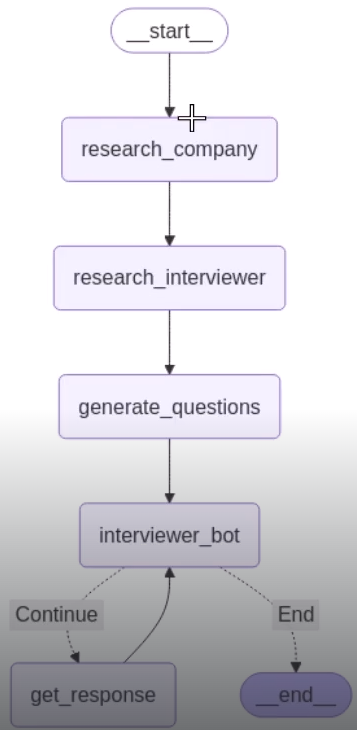

# Setup

In [ ]:
from google.colab import userdata
import os

openai_api_key = userdata.get('ai_agents_openai')
os.environ['OPENAI_API_KEY'] = openai_api_key

serper_api_key = userdata.get('serper_api')
os.environ['SERPER_API_KEY'] = serper_api_key

In [ ]:
# !pip install -q langchain-community langchain-openai langgraph

In [ ]:
from openai import OpenAI

from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import START, StateGraph, END

from IPython.display import Markdown, Image
from typing_extensions import TypedDict

import json
import ast

In [ ]:
# OpenAI Client
client = OpenAI()

In [ ]:
COMPANY = "The Bitcoin Way"
INTERVIEWER = "Tony Yabeck"
LOCATION = "PA"
POSITION = "Bitcoin Self-Custody Specialist"
BACKGROUND = [
    "The Bitcoin Way is seeking a Bitcoin Self-Custody Expert.",
    "This role requires deep technical knowledge and strong people skills.",
    "Key Responsibilities:",
    "Guide clients on Bitcoin wallet, node, and infrastructure setup and security.",
    "Provide one-on-one consultations on Bitcoin self-custody best practices.",
    "Stay updated on Bitcoin, open-source tools, cybersecurity, and privacy.",
    "Align with the mission: empowering individuals with Bitcoin sovereignty.",
    "Requirements:",
    "Availability for US PM hours.",
    "Strong knowledge of: Bitcoin wallets (hardware & software), Nodes, Open-source software, Cybersecurity & privacy.",
    "Must be a Bitcoiner first.",
    "Experience working directly with people, explaining technical concepts clearly and with empathy.",
    "A visible profile in the Bitcoin community is a plus.",
    "Application requires email with details on: About You, Social Profiles & Work, Top 3 Hardware Wallets, Node Experience, and People Skills.",
]

# Research the Company

In [ ]:
# Researching the company on the web
def research_company(state):

  state['company'] = COMPANY
  state['location'] = LOCATION

  print('———Researching Company———')
  response = client.responses.create(
      model = "gpt-4.1",
      tools = [{"type": "web_search_preview",
              "user_location": {
                  "type": "approximate",
                  "country": state['location'],
              }}],
      input = f"Research {state['company']}.",
  )

  # Store the outcome.
  state['company_data'] = response.output_text

  # display(Markdown(state['company_data']))
  return state


## Research Interviewer

In [ ]:
# Build function to research the interviewer
def research_interviewer(state):

  state['company'] = COMPANY
  state['interviewer'] = INTERVIEWER
  state['location'] = LOCATION

  print('———Researching Interviewer———')
  response = client.responses.create(
      model = "gpt-4.1",
      tools = [{"type": "web_search_preview",
              "user_location": {
                  "type": "approximate",
                  "country": state['location'],
              },
                "search_context_size": "medium" # provide balanced scope
                }],
      input = f"""
      Research {state['interviewer']},
      who works for {state['company']},
      located in {state['location']}.
      """,
  )

  # Update the AgentState
  state['interviewer_data'] = response.output_text
  # display(Markdown(state['interviewer_data']))
  return state

## Generate Interview Questions

In [ ]:
def generate_questions(state):

  state['position'] = POSITION
  state['background'] = BACKGROUND

  developer_message = f"""
    You are an AI that generates interview questions.

    **********
    DATA
    **********

    Company Name: {state['company']}
    Company Report from web search: {state['company_data']}

    Interviewer Name: {state['interviewer']}
    Interviewer Report from web search: {state['interviewer_data']}

    Job Position: {state['position']}
    User Background: {state['background']}

    **********
    OUTPUT
    **********

    1) 10 concise questions in bullet point form to mimic a job interiew.
    2) Questions may touch upon the user's background, culture fit, job fit, or qualifications.

    """

  print("———Generating Questions———")

  response = client.responses.create(
      model = "gpt-4.1",
      input = [{"role": "developer", "content": developer_message}],

  )

  state['questions'] = response.output_text

  return state

## Interviewer Bot

In [ ]:
def interviewer_bot(state):

  if not state.get('memory'):
    state['memory'] = []

  developer_message = f"""
  You are an AI that helps the user prepare for a job interview.
  You follow a predefined script.
  Ask the questions exactly as given, in order.
  After the answer of the user, give actionable feedback to the role.

  **********
  DATA
  **********
  Company Name: {state['company']}
  Position: {state['position']}
  User Background: {state['background']}
  Questions: {state['questions']}
  Memory: {state['memory']}
  """

  print("———Interviewing———")
  response = client.responses.create(
      model = "gpt-4.1",
      input = [{"role": "developer", "content": developer_message}],
  )

  question = response.output_text
  display(Markdown(question))
  state['memory'].append(question)

  return state

## Get Response

In [ ]:
# Build a function to get an answer.
def get_answer(state):

  print('Please provide answer.')
  print("\n(Type 'quit', 'exit', 'stop' or 'end' to terminate session.)")
  user_input = input()
  state['memory'].append(f"User: {user_input}")
  state['terminate'] = user_input.lower().strip() in ['quit', 'exit', 'stop', 'end']

  return state


## Routers

In [ ]:
# Function that decides the terminate the flow.
def termination_router(state):
  return "End" if state.get('terminate') else "Continue"

## Build Workflow

### The Agent State which the AI uses to store the information.

In [ ]:
# Create a TypedDict class to store information.
class AgentState(TypedDict):

    # Initial Data
    company: str
    location: str # country, ISO Code
    position: str
    background: list
    interviewer: str

    # Generated Content
    company_data: str
    interviewer_data: str
    questions: str

    # App Keys
    memory: list

### Workflow
The AgentState is passed through the ´StateGraph´ and is referenced in all funcitons.

In [ ]:
# Initializing StateGraph
workflow = StateGraph(AgentState)

# Set Entry Point
workflow.set_entry_point('Research Company')

# Define Nodes
workflow.add_node('Research Company', research_company)
workflow.add_node('Research Interviewer', research_interviewer)
workflow.add_node('Generate Questions', generate_questions)
workflow.add_node('Interview Bot', interviewer_bot)
workflow.add_node('Get Answer', get_answer)

# Define Edges
workflow.add_edge('Research Company', 'Research Interviewer')
workflow.add_edge('Research Interviewer', 'Generate Questions')
workflow.add_edge('Generate Questions', 'Interview Bot')
workflow.add_edge('Interview Bot', 'Get Answer')

# Add a conditional edge
workflow.add_conditional_edges(
    "Get Answer",
    termination_router,
    {
        "Continue": "Interview Bot",
        "End": END
    }
)

# Compile Workflow
app = workflow.compile()

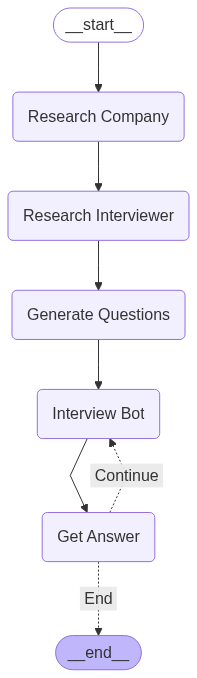

In [ ]:
# Display Graph
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
result = app.invoke({'recursion_limit': 50})

———Researching Company———
———Researching Interviewer———
———Generating Questions———
———Interviewing———


Can you describe your experience setting up and securing Bitcoin wallets, including both hardware and software options?

Please provide answer.

(Type 'quit', 'exit', 'stop' or 'end' to terminate session.)
I just use Cold Card, Strike — a combination of KYC and non-KYC.
———Interviewing———


Great, thank you for sharing your experience. Here’s some actionable feedback:

Feedback:
- It's good that you mentioned specific wallets (Coldcard, Strike), which shows direct experience.
- To strengthen your answer for this role, try to:
    - Emphasize your understanding of both hardware (e.g., Coldcard, Ledger, Trezor) and a range of software wallets (BlueWallet, Sparrow, Electrum, etc.).
    - Highlight your process for securing these wallets (backups, passphrase use, multi-sig setups, secure device storage).
    - Discuss how you guide others through the setup and security process, as you'll be supporting clients with varying experience levels.

Let’s move to the next question:

What are your top 3 recommended hardware wallets, and why do you prefer them for client self-custody?

Please provide answer.

(Type 'quit', 'exit', 'stop' or 'end' to terminate session.)
Cold Card, because it's the most secure. Yes, it does require some technical know-how and you have to watch some YouTube videos to fully grok all of its features, but in the end, you can see all of the source code, and the private keys are completely airgapped.
———Interviewing———


Thank you for your response.

Feedback:
- You provided a clear top recommendation (Coldcard) and explained the security benefits, open-source code, and air-gapped private keys, which is excellent for this audience.
- For a well-rounded answer tailored to The Bitcoin Way, try to:
    - List your full top 3 with short reasons for each.
    - Compare them based on user experience, security, price, and availability, showing you can match wallets to different clients’ needs.
    - Mention how you assess which wallet is best for a particular client based on their technical comfort and goals.

Let’s move to the next question:

Have you installed and operated your own Bitcoin node? Please explain your experience and any challenges you’ve faced.

Please provide answer.

(Type 'quit', 'exit', 'stop' or 'end' to terminate session.)
Yes, I have my own Bitcoin node. It wasn't very hard. Just downloaded it from the Bitcoin Core website, made sure to verify the integrity with sha256sum, and then downloaded the UTXO ledgers. But now there is a debate between Bitcoin Core and Bitcoin Knots, because Knots filters out any non-monetary transactions.
———Interviewing———


Thank you for describing your node setup experience.

Feedback:
- You clearly outlined the steps you took: downloading Bitcoin Core, verifying the binary, and syncing the blockchain, which demonstrates your technical competence.
- Noting the current technical debate between Core and Knots shows you’re aware of ongoing development in the ecosystem.
- To further strengthen your answer for The Bitcoin Way’s role:
    - Discuss any practical challenges you faced (e.g., hardware requirements, network speed, troubleshooting issues during sync, firewall/router configurations) and how you resolved them.
    - Mention if you’ve set up nodes for others (clients, friends) or integrated them with wallets or additional tools (e.g., Electrum server, Lightning node).
    - Reflect on how you use your node to enhance privacy and sovereignty—for yourself and as guidance for clients.

Let’s continue:

How do you keep your technical knowledge up-to-date regarding Bitcoin developments and open-source tools?

Please provide answer.

(Type 'quit', 'exit', 'stop' or 'end' to terminate session.)
exit
